# <center> meta-QCNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
from jax.config import config

config.update("jax_enable_x64", True)
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## energy
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [16]:
# j=1, Bx=1
def energy(c: tc.Circuit, j: float = 1.0, hx: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e -= hx * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n-1):  
        e += j * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i+1])
        )  # <Z_i Z_{i+1}>
    return tc.backend.real(e)

## meta-QCNN net

In [14]:
def QCNN(params, n, hx):
    params = tc.backend.cast(params, "complex128")
    hx = tc.backend.cast(hx, "complex128")
    c = tc.Circuit(n)
    
    idx = 0
    
    # encoding layer
    for i in range(n):
        c.rx(i, theta=(params[4*i] * hx + params[4*i+1]))
        c.rz(i, theta=(params[4*i+2] * hx + params[4*i+1+3]))
    idx += 4*n
    
    for i in range(0, n-1, 2):
        c.cnot(i, i+1)
    
    for i in range(n):
        c.rx(i, theta=params[2*i])
        c.rz(i, theta=params[2*i+1])
    idx += 2*n
    
    
    # processing layer
    for n_layer in range(int(np.log2(n)), 0, -1):
        n_qubit = 2**n_layer   # 参与计算的qubit数
        step = int(n / n_qubit)

        # even    
        for i in range(step, n-step, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        # odd   
        for i in range(0, n, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx+1])
            idx += 2
        
        # c.barrier()

    # measure
    #e = energy(c, hx=hx)
    return c, idx
    #return e

98


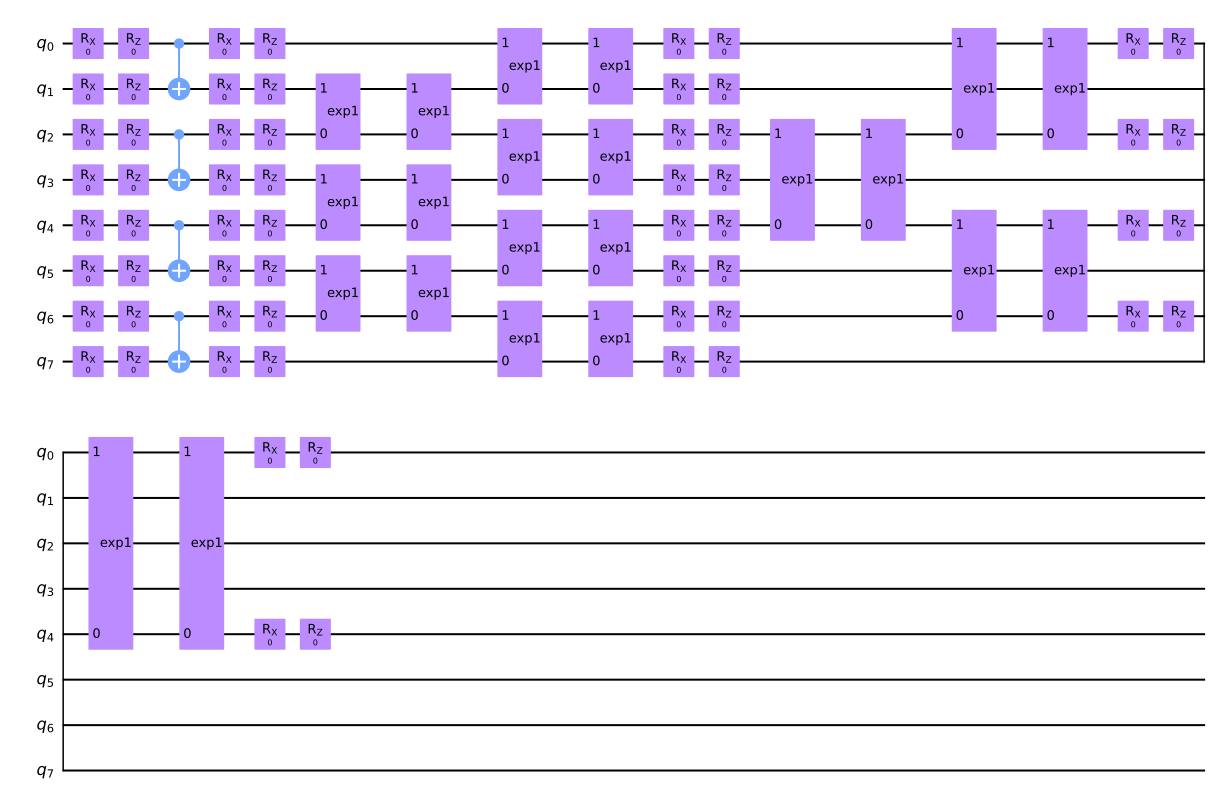

In [6]:
cirq, idx = QCNN(np.zeros(1000), 8, 1)
print(idx)
cirq.draw()

In [7]:
def meta_QCNN(params, n, hx):
    e_all = tf.zeros([1], dtype=tf.float64)
    for h in hx:
        e_all += QCNN(params, n, h)
        
    return e_all

## train

In [8]:
meta_QCNN_tfim_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(meta_QCNN)
)

def batched_train(n, hx, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    best_params = None
    for i in range(maxiter):
        e, grad = meta_QCNN_tfim_vvag(params, n, hx)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e)<lowest_energy:
            lowest_energy = tf.reduce_min(e)
            best_params = params[tf.argmin(e).numpy()[0]]
        if i % 200 == 0:
            print(e)
    return lowest_energy, best_params

In [11]:
n = 8
hx = tf.random.uniform(
    shape=[10], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
with tf.device('/cpu:0'):
    energy, best_params = batched_train(n, hx, batch=5, maxiter=3000, lr=0.007)

tf.Tensor(
[[ 6.06961585]
 [-1.03952284]
 [ 8.64983652]
 [-1.19468754]
 [-3.87061151]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-86.08300221]
 [-86.99420873]
 [-87.252466  ]
 [-85.85372132]
 [-86.95237839]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-88.94344983]
 [-88.75683505]
 [-89.1431111 ]
 [-88.2279078 ]
 [-88.73269678]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-89.72045748]
 [-89.47699149]
 [-89.70874904]
 [-89.51523122]
 [-89.4667797 ]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-89.96344564]
 [-89.86289879]
 [-89.9287375 ]
 [-90.1463857 ]
 [-89.81144581]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-90.01922817]
 [-90.14435847]
 [-90.0438208 ]
 [-90.40399739]
 [-90.34058704]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-90.0775494 ]
 [-90.39740101]
 [-90.16968736]
 [-90.57412527]
 [-90.75208914]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-90.2170455 ]
 [-90.60030209]
 [-90.29873671]
 [-90.72220845]
 [-90.90029221]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-90.52941177]
 [

## compare

In [17]:
# Creating test data
from tqdm.notebook import tqdm
test_hx = tf.random.uniform(
    shape=[100], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
test_energies = tf.zeros_like(test_hx).numpy()

for i, h in tqdm(enumerate(test_hx)):
    test_energies[i] = QCNN(best_params, n, h).numpy()

0it [00:00, ?it/s]

In [24]:
import quimb
DMRG_energies = []
for i in np.linspace(0,1.6,17):
    h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=4.0, bx=2*i, S=0.5, cyclic=False)  # Ising Hamiltonian in MPO form (number, zz interaction strenth, x-magnetic field strenth)
    dmrg = quimb.tensor.tensor_dmrg.DMRG(h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13)
    dmrg.solve(tol=1e-9, verbosity=0)
    DMRG_energies.append(dmrg.energy)

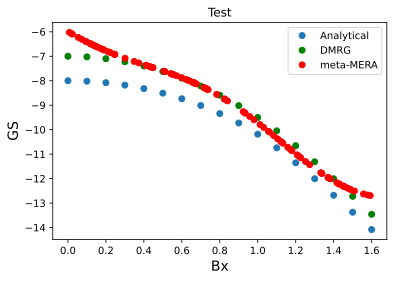

In [25]:
plt.plot(np.linspace(0,1.6,17), DMRG_energies, 'bo', label='DMRG')
plt.plot(test_hx, test_energies, 'ro', label='meta-QCNN')
plt.title("Test")
plt.xlabel("Bx", fontsize=14)
plt.ylabel("GS", fontsize=14)
plt.legend()
plt.show()

In [26]:
energy, best_params

(<function __main__.energy(c: tensorcircuit.circuit.Circuit, j: float = 1.0, hx: float = 1.0)>,
 <tf.Tensor: shape=(98,), dtype=float64, numpy=
 array([ 1.36255479e-01, -2.59736751e-01, -1.63854011e+00,  4.18666681e-01,
        -3.25472625e-01, -2.66381656e-01,  1.08691388e-01, -1.44898110e+00,
        -1.57675723e+00,  6.25643969e-01, -1.56849279e+00,  2.63655197e+00,
        -8.68113613e-01, -1.78734171e-01,  2.74198766e-01, -2.01674406e+00,
         1.18533626e+00, -3.34695849e-01, -6.30491711e-01, -9.54716167e-01,
         7.96457424e-01, -1.86305571e+00, -9.72763981e-02,  1.59076773e+00,
         3.15411400e-02, -2.23357584e+00,  9.47902423e-01, -1.41777143e+00,
        -9.26780354e-01, -8.54026940e-01, -3.24530909e-01,  4.95210160e-01,
         5.67840813e-01,  5.66218688e-01, -1.04886348e+00,  1.90893556e+00,
         5.65615559e-01,  5.60985697e-02,  3.80234202e-01,  3.29503009e-01,
        -1.60854303e+00, -3.98376453e-02, -2.35334591e+00, -1.79084478e-01,
        -8.63357080e

In [20]:
test_hx, test_energies

(<tf.Tensor: shape=(100,), dtype=float64, numpy=
 array([0.73305489, 1.47155667, 1.17047109, 0.18467471, 0.62133105,
        0.57299463, 0.245914  , 1.25200786, 1.05685454, 1.43063951,
        0.5515871 , 0.1472079 , 0.82625295, 1.3729823 , 0.98016337,
        0.71675129, 1.22651309, 0.09895739, 1.21583158, 0.37304518,
        0.05434584, 0.93297045, 0.30114021, 1.10469989, 0.82435921,
        0.34905387, 0.50561155, 0.42950465, 0.92361401, 1.59249243,
        0.66728608, 0.1280813 , 1.13295303, 0.11884182, 1.01236536,
        1.12268572, 1.55724244, 0.44796768, 0.73072902, 0.63959226,
        1.1583427 , 0.41496976, 0.00761908, 0.54212496, 0.5123801 ,
        0.24397028, 1.33253176, 1.33817555, 1.27357975, 1.17998942,
        0.24737624, 1.08357004, 1.20739505, 1.06153002, 1.48680821,
        0.11761419, 1.12459338, 0.14248135, 0.78370371, 1.41723423,
        0.44534252, 1.3708766 , 0.66230942, 1.57883472, 1.50918076,
        0.65666008, 1.33476229, 1.447322  , 0.43700986, 1.48737773,